In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split

import xgboost as xgb

from sklearn.metrics import roc_auc_score, r2_score, mean_squared_error, classification_report

In [2]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import ElasticNet

In [3]:
train=pd.read_csv("../data/train/datacontinuousstudents_train.csv")
train=train.drop(['id'], axis=1)
#train.head()

In [4]:
X_train=train.drop(['y'], axis=1)
Y_train=train['y']
X_train.shape, Y_train.shape

((120, 32), (120,))

In [5]:
test=pd.read_csv("../data/test/datacontinuousstudents_test.csv")
test=test.drop(['id'], axis=1)
#test.head()

In [6]:
X_test=test.drop(['y'], axis=1)
Y_test=test['y']
X_test.shape, Y_test.shape

((30, 32), (30,))

#### Análisis variables numéricas vs target

Resumen estadístico

In [7]:
train.describe()

,y,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x23,x24,x25,x26,x27,x28,x29,x30,x31,x32
count,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,...,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000
mean,0.513959,64.574126,49.281667,0.300000,0.141667,0.041667,0.108333,0.083333,15.299094,27.791667,...,0.219333,0.039371,6.366667,5.558333,81.542031,0.108333,0.050000,3.841667,0.281920,0.489820
std,2.250778,9.488580,40.817030,0.460179,0.350170,0.200664,0.312104,0.277544,1.937916,15.292056,...,0.342694,0.149234,0.897553,1.002483,48.853216,0.312104,0.218859,2.153738,0.191636,0.295519
min,-6.143410,41.696000,4.600000,0.000000,0.000000,0.000000,0.000000,0.000000,10.617270,0.000000,...,0.000000,0.000000,4.000000,3.000000,13.533800,0.000000,0.000000,1.000000,0.016302,0.032387
25%,-0.849932,57.820250,14.975000,0.000000,0.000000,0.000000,0.000000,0.000000,14.282493,27.000000,...,0.001375,0.000000,6.000000,5.000000,46.428100,0.000000,0.000000,2.000000,0.099620,0.191323
50%,0.563972,67.946500,36.300000,0.000000,0.000000,0.000000,0.000000,0.000000,15.437490,31.000000,...,0.019950,0.000100,6.000000,6.000000,69.777400,0.000000,0.000000,4.000000,0.247636,0.455207
75%,2.237177,71.359000,76.150000,1.000000,0.000000,0.000000,0.000000,0.000000,16.399015,40.250000,...,0.239000,0.001850,7.000000,6.000000,105.504000,0.000000,0.000000,6.000000,0.426950,0.795187
max,6.800272,78.836829,173.700000,1.000000,1.000000,1.000000,1.000000,1.000000,20.584160,45.000000,...,0.991800,0.846600,8.000000,7.000000,344.830000,1.000000,1.000000,7.000000,0.662330,0.996328


Correlación

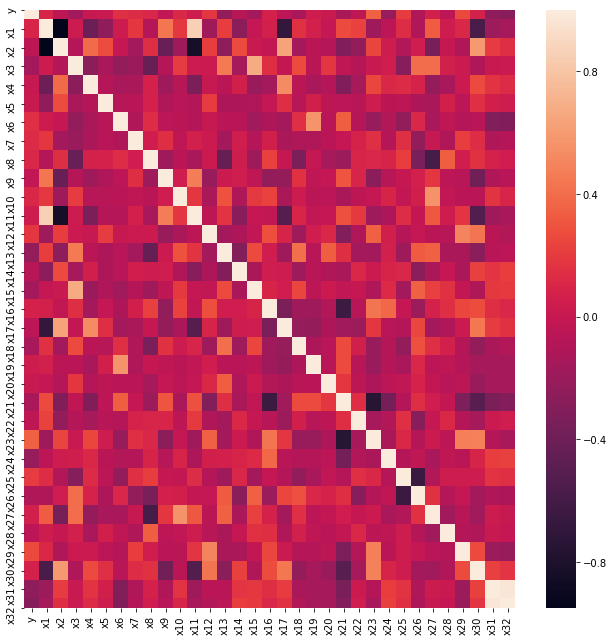

In [8]:
corrmat = train.corr()
fig, ax = plt.subplots()
fig.set_size_inches(11,11)
sns.heatmap(corrmat)

Estandarización de regresoras Train

In [9]:
num_features = ['x1','x2','x8','x9','x10','x11','x12','x21','x22','x23','x24','x25','x26','x27','x30','x31','x32']

In [10]:
num_pipeline = Pipeline([
    ('scaler',StandardScaler()),
    ('imputer',SimpleImputer(strategy='median'))
])

col_transformer = ColumnTransformer(transformers=[
    ('num', num_pipeline, num_features)
])

In [11]:
columns=X_train.columns.values.tolist()

In [12]:
col_transformer.fit(X_train.fillna(0))

ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
                  transformer_weights=None,
                  transformers=[('num',
                                 Pipeline(memory=None,
                                          steps=[('scaler',
                                                  StandardScaler(copy=True,
                                                                 with_mean=True,
                                                                 with_std=True)),
                                                 ('imputer',
                                                  SimpleImputer(add_indicator=False,
                                                                copy=True,
                                                                fill_value=None,
                                                                missing_values=nan,
                                                                strategy='median',
                      

In [13]:
X_train[num_features]=col_transformer.transform(X_train.fillna(0))

Estandarización de regresoras Test

In [14]:
X_test[num_features]=col_transformer.transform(X_test.fillna(0))

Selección de variables

In [15]:
# Modelo con todas las características para determinar importancia

seed_val = 99
np.random.seed(seed_val)

model_all_features = xgb.XGBRegressor(
    nthread=10, max_depth=4, n_estimators=500, learning_rate=0.05)

model_all_features.fit(X_train, Y_train)

y_pred_test = model_all_features.predict(X_test)
mse_score_all = mean_squared_error(Y_test, y_pred_test)
print('Test all features xgb R2 = %f' % (mse_score_all))

C:\Users\Juan Camilo Ceballos\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\Juan Camilo Ceballos\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[14:57:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Test all features xgb R2 = 4.509732


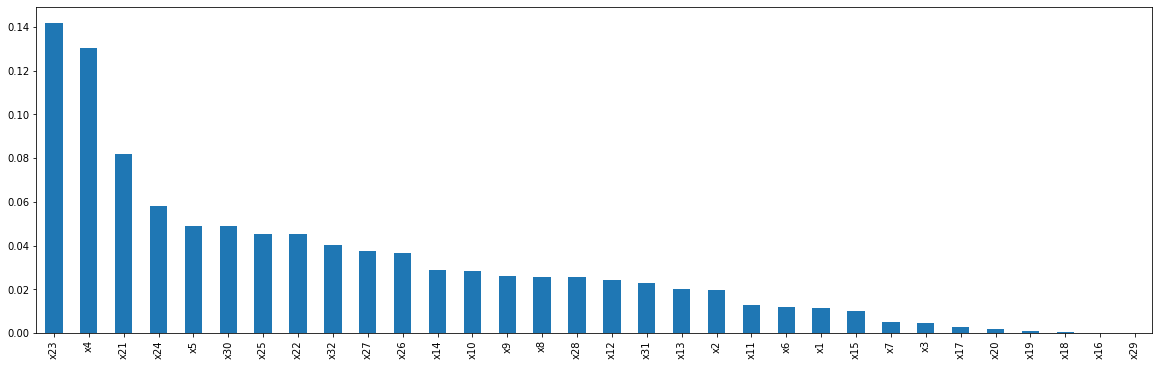

In [16]:
features = pd.Series(model_all_features.feature_importances_)
features.index = X_train.columns

features.sort_values(ascending=False, inplace=True)

features.plot.bar(figsize=(20,6))

In [17]:
features = list(features.index)
features

['x23',
 'x4',
 'x21',
 'x24',
 'x5',
 'x30',
 'x25',
 'x22',
 'x32',
 'x27',
 'x26',
 'x14',
 'x10',
 'x9',
 'x8',
 'x28',
 'x12',
 'x31',
 'x13',
 'x2',
 'x11',
 'x6',
 'x1',
 'x15',
 'x7',
 'x3',
 'x17',
 'x20',
 'x19',
 'x18',
 'x16',
 'x29']

In [18]:
# Modelo con la característca más importante (desde la que se inicia la adición)

seed_val = 99
np.random.seed(seed_val)

model_one_feature = xgb.XGBRegressor(
    nthread=10, max_depth=4, n_estimators=500, learning_rate=0.05)

model_one_feature.fit(X_train[features[0]].to_frame(), Y_train)

y_pred_test = model_one_feature.predict(X_test[features[0]].to_frame())
mse_score_first = mean_squared_error(Y_test, y_pred_test)
print('Test one feature xgb R2=%f' % (mse_score_first))

C:\Users\Juan Camilo Ceballos\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\Juan Camilo Ceballos\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[14:57:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Test one feature xgb R2=6.714750


In [19]:
# Adición de características y evaluación de modelos, una a la vez (en orden de importancia)

tol = 0.001

print('doing recursive feature addition')

features_to_keep = [features[0]]

count = 1

for feature in features[1:]:
    print()
    print('testing feature: ', feature, ' which is feature ', count,
          ' out of ', len(features))
    count = count + 1

    model_int = xgb.XGBRegressor(
        nthread=10, max_depth=4, n_estimators=500, learning_rate=0.05)

    model_int.fit(
        X_train[features_to_keep + [feature] ], Y_train)

    y_pred_test = model_int.predict(
        X_test[features_to_keep + [feature] ])

    mse_score_int = mean_squared_error(Y_test, y_pred_test)
    print('New Test mse={}'.format((mse_score_int)))

    print('All features Test mse={}'.format((mse_score_first)))

    diff_mse = mse_score_first - mse_score_int 

    if diff_mse >= tol:
        print('Decrease in mse = {}'.format(diff_mse))
        print('keep: ', feature)
        print

        mse_score_first = mse_score_int

        features_to_keep.append(feature)
    else:
        print('Decrease in r2 = {}'.format(diff_mse))
        print('remove: ', feature)
        print

print()
print('DONE!!')
print('total features to keep: ', len(features_to_keep))
print('selected features: ', features_to_keep)
print('final test mse score={}'.format(mse_score_first))

doing recursive feature addition

testing feature:  x4  which is feature  1  out of  32
[14:57:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\Juan Camilo Ceballos\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\Juan Camilo Ceballos\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


New Test mse=5.779293797601485
All features Test mse=6.714749571760209
Decrease in mse = 0.9354557741587239
keep:  x4

testing feature:  x21  which is feature  2  out of  32
[14:57:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\Juan Camilo Ceballos\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\Juan Camilo Ceballos\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


New Test mse=6.420150609224871
All features Test mse=5.779293797601485
Decrease in r2 = -0.6408568116233857
remove:  x21

testing feature:  x24  which is feature  3  out of  32
[14:57:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\Juan Camilo Ceballos\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\Juan Camilo Ceballos\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


New Test mse=6.079998821710272
All features Test mse=5.779293797601485
Decrease in r2 = -0.30070502410878674
remove:  x24

testing feature:  x5  which is feature  4  out of  32
[14:57:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\Juan Camilo Ceballos\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\Juan Camilo Ceballos\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


New Test mse=5.2595212998927225
All features Test mse=5.779293797601485
Decrease in mse = 0.5197724977087628
keep:  x5

testing feature:  x30  which is feature  5  out of  32
[14:57:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\Juan Camilo Ceballos\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\Juan Camilo Ceballos\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


New Test mse=4.282767933982042
All features Test mse=5.2595212998927225
Decrease in mse = 0.9767533659106808
keep:  x30

testing feature:  x25  which is feature  6  out of  32
[14:57:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\Juan Camilo Ceballos\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\Juan Camilo Ceballos\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


New Test mse=3.818988577483405
All features Test mse=4.282767933982042
Decrease in mse = 0.46377935649863655
keep:  x25

testing feature:  x22  which is feature  7  out of  32
[14:57:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\Juan Camilo Ceballos\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\Juan Camilo Ceballos\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


New Test mse=3.0808305668297202
All features Test mse=3.818988577483405
Decrease in mse = 0.7381580106536849
keep:  x22

testing feature:  x32  which is feature  8  out of  32
[14:57:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\Juan Camilo Ceballos\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\Juan Camilo Ceballos\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


New Test mse=2.7429329370622315
All features Test mse=3.0808305668297202
Decrease in mse = 0.3378976297674887
keep:  x32

testing feature:  x27  which is feature  9  out of  32
[14:57:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\Juan Camilo Ceballos\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\Juan Camilo Ceballos\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


New Test mse=3.018761977054667
All features Test mse=2.7429329370622315
Decrease in r2 = -0.27582903999243547
remove:  x27

testing feature:  x26  which is feature  10  out of  32
[14:57:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\Juan Camilo Ceballos\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\Juan Camilo Ceballos\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


New Test mse=3.046393172017057
All features Test mse=2.7429329370622315
Decrease in r2 = -0.30346023495482566
remove:  x26

testing feature:  x14  which is feature  11  out of  32
[14:57:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\Juan Camilo Ceballos\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\Juan Camilo Ceballos\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


New Test mse=3.254795297259461
All features Test mse=2.7429329370622315
Decrease in r2 = -0.5118623601972296
remove:  x14

testing feature:  x10  which is feature  12  out of  32
[14:57:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\Juan Camilo Ceballos\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\Juan Camilo Ceballos\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


New Test mse=3.6341541152676116
All features Test mse=2.7429329370622315
Decrease in r2 = -0.89122117820538
remove:  x10

testing feature:  x9  which is feature  13  out of  32
[14:57:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\Juan Camilo Ceballos\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\Juan Camilo Ceballos\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


New Test mse=3.4812253596331146
All features Test mse=2.7429329370622315
Decrease in r2 = -0.7382924225708831
remove:  x9

testing feature:  x8  which is feature  14  out of  32
[14:57:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\Juan Camilo Ceballos\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\Juan Camilo Ceballos\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


New Test mse=3.371094670795951
All features Test mse=2.7429329370622315
Decrease in r2 = -0.6281617337337195
remove:  x8

testing feature:  x28  which is feature  15  out of  32
[14:57:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\Juan Camilo Ceballos\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\Juan Camilo Ceballos\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


New Test mse=3.0739739696661728
All features Test mse=2.7429329370622315
Decrease in r2 = -0.33104103260394124
remove:  x28

testing feature:  x12  which is feature  16  out of  32
[14:57:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\Juan Camilo Ceballos\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\Juan Camilo Ceballos\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


New Test mse=3.611189289242421
All features Test mse=2.7429329370622315
Decrease in r2 = -0.8682563521801896
remove:  x12

testing feature:  x31  which is feature  17  out of  32
[14:57:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\Juan Camilo Ceballos\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\Juan Camilo Ceballos\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


New Test mse=3.4707635366911065
All features Test mse=2.7429329370622315
Decrease in r2 = -0.727830599628875
remove:  x31

testing feature:  x13  which is feature  18  out of  32
[14:57:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\Juan Camilo Ceballos\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\Juan Camilo Ceballos\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


New Test mse=3.238050076445694
All features Test mse=2.7429329370622315
Decrease in r2 = -0.4951171393834626
remove:  x13

testing feature:  x2  which is feature  19  out of  32
[14:57:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\Juan Camilo Ceballos\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\Juan Camilo Ceballos\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


New Test mse=3.6014102319423142
All features Test mse=2.7429329370622315
Decrease in r2 = -0.8584772948800827
remove:  x2

testing feature:  x11  which is feature  20  out of  32
[14:57:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\Juan Camilo Ceballos\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\Juan Camilo Ceballos\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


New Test mse=3.9386801635497335
All features Test mse=2.7429329370622315
Decrease in r2 = -1.195747226487502
remove:  x11

testing feature:  x6  which is feature  21  out of  32
[14:57:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\Juan Camilo Ceballos\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\Juan Camilo Ceballos\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


New Test mse=3.124456481667392
All features Test mse=2.7429329370622315
Decrease in r2 = -0.3815235446051606
remove:  x6

testing feature:  x1  which is feature  22  out of  32
[14:57:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\Juan Camilo Ceballos\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\Juan Camilo Ceballos\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


New Test mse=3.5390142417325836
All features Test mse=2.7429329370622315
Decrease in r2 = -0.7960813046703521
remove:  x1

testing feature:  x15  which is feature  23  out of  32
[14:57:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\Juan Camilo Ceballos\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\Juan Camilo Ceballos\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


New Test mse=2.786147522710451
All features Test mse=2.7429329370622315
Decrease in r2 = -0.04321458564821956
remove:  x15

testing feature:  x7  which is feature  24  out of  32
[14:57:39] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\Juan Camilo Ceballos\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\Juan Camilo Ceballos\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


New Test mse=2.8299160745152885
All features Test mse=2.7429329370622315
Decrease in r2 = -0.08698313745305697
remove:  x7

testing feature:  x3  which is feature  25  out of  32
[14:57:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\Juan Camilo Ceballos\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\Juan Camilo Ceballos\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


New Test mse=3.039975485527871
All features Test mse=2.7429329370622315
Decrease in r2 = -0.2970425484656394
remove:  x3

testing feature:  x17  which is feature  26  out of  32
[14:57:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\Juan Camilo Ceballos\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\Juan Camilo Ceballos\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


New Test mse=2.598340104904743
All features Test mse=2.7429329370622315
Decrease in mse = 0.14459283215748853
keep:  x17

testing feature:  x20  which is feature  27  out of  32
[14:57:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\Juan Camilo Ceballos\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\Juan Camilo Ceballos\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


New Test mse=2.9297035161875598
All features Test mse=2.598340104904743
Decrease in r2 = -0.33136341128281677
remove:  x20

testing feature:  x19  which is feature  28  out of  32
[14:57:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\Juan Camilo Ceballos\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\Juan Camilo Ceballos\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


New Test mse=2.668640046934542
All features Test mse=2.598340104904743
Decrease in r2 = -0.07029994202979895
remove:  x19

testing feature:  x18  which is feature  29  out of  32
[14:57:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\Juan Camilo Ceballos\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\Juan Camilo Ceballos\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


New Test mse=2.591048657182164
All features Test mse=2.598340104904743
Decrease in mse = 0.007291447722578948
keep:  x18

testing feature:  x16  which is feature  30  out of  32
[14:57:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\Juan Camilo Ceballos\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\Juan Camilo Ceballos\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


New Test mse=2.791694209897177
All features Test mse=2.591048657182164
Decrease in r2 = -0.20064555271501305
remove:  x16

testing feature:  x29  which is feature  31  out of  32
[14:57:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\Juan Camilo Ceballos\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\Juan Camilo Ceballos\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


New Test mse=2.883570766789424
All features Test mse=2.591048657182164
Decrease in r2 = -0.2925221096072601
remove:  x29

DONE!!
total features to keep:  9
selected features:  ['x23', 'x4', 'x5', 'x30', 'x25', 'x22', 'x32', 'x17', 'x18']
final test mse score=2.591048657182164


In [20]:
# Modelo con características seleccionadas

seed_val = 99
np.random.seed(seed_val)

final_xgb = xgb.XGBRegressor(
    nthread=10, max_depth=4, n_estimators=500, learning_rate=0.05)

final_xgb.fit(X_train[features_to_keep], Y_train)

y_pred_test = final_xgb.predict(X_test[features_to_keep])

r2_score_final = r2_score(Y_test, y_pred_test)
print('Test selected features R2=%f' % (r2_score_final))

mse = mean_squared_error(Y_test, y_pred_test)
print('Test selected features mse=%f' % (mse))

[14:57:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\Juan Camilo Ceballos\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\Juan Camilo Ceballos\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


Test selected features R2=0.148975
Test selected features mse=2.591049


In [21]:
to_export = pd.concat([Y_test, pd.DataFrame(y_pred_test)],axis=1)

In [22]:
to_export.columns=['real','guess']

In [23]:
to_export

,real,guess
0,0.685760,-1.422376
1,-1.290415,0.165981
2,2.300179,0.294992
3,1.147798,3.958023
4,0.523130,-1.081972
5,-1.372723,-2.081614
6,-3.427594,-1.352126
7,1.185463,1.454469
8,-0.559505,-1.047070
9,2.099727,1.481904


In [24]:
#to_export.to_csv('./validation/continua/camilo.csv')

Conversión

In [25]:
y_pred_test=np.where(y_pred_test<=-1, 0, 1)

In [26]:
Y_test=np.where(Y_test<=-1, 0, 1)

In [27]:
print(classification_report(Y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.40      0.29      0.33         7
           1       0.80      0.87      0.83        23

    accuracy                           0.73        30
   macro avg       0.60      0.58      0.58        30
weighted avg       0.71      0.73      0.72        30



In [28]:
pd.crosstab(Y_test,y_pred_test,rownames=["Actual"],colnames=["Predictions"])

Predictions,0,1
Actual,,
0,2,5
1,3,20
